In [39]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import *
import seaborn as sns
import PIL
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.applications import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
import os
print("tf Version = ",tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

tf Version =  2.19.0
Num GPUs Available:  1


In [40]:
batch_size = 16
img_height = 224
img_width = 224
data_dir = 'datasets/chest_xray/'

In [41]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,  # First split: 70% training, 30% for val+test
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 5856 files belonging to 2 classes.
Using 4100 files for training.


In [42]:
remaining_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,  # Taking the remaining 30%
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 5856 files belonging to 2 classes.
Using 1756 files for validation.


In [43]:
val_batches = tf.data.experimental.cardinality(remaining_ds) // 2
test_batches = val_batches

In [44]:
val_ds = remaining_ds.take(val_batches)
test_ds = remaining_ds.skip(val_batches)

In [45]:
class_names = train_ds.class_names
num_classes = len(class_names)
print('ชื่อคลาส: ',class_names)
print('จำนวนคลาส: ',num_classes)

ชื่อคลาส:  ['NORMAL', 'PNEUMONIA']
จำนวนคลาส:  2


(16, 224, 224, 3)
(16,)


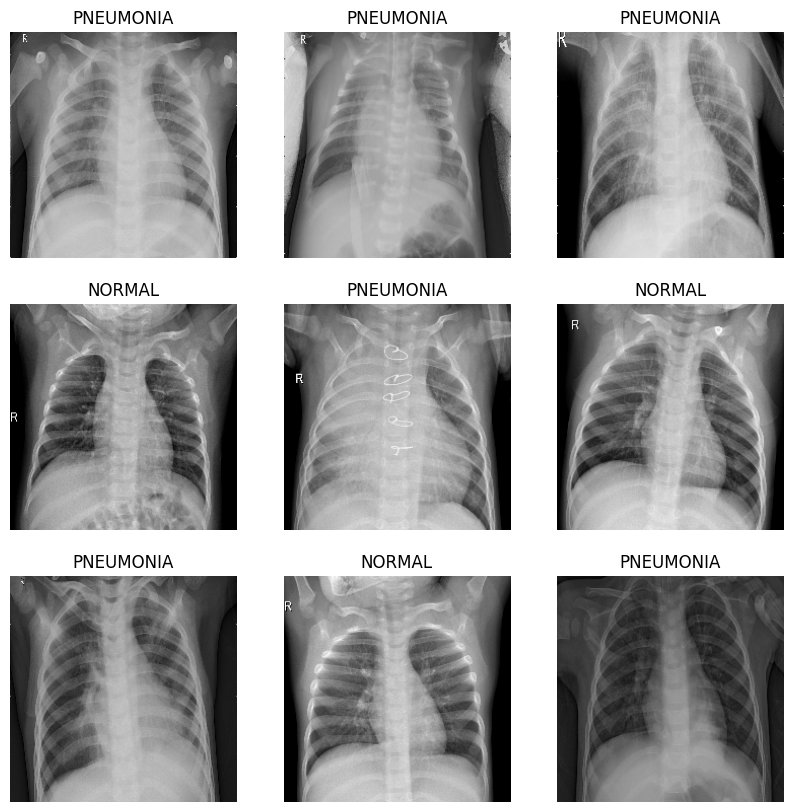

In [46]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

In [47]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [48]:
normalization_layer = layers.Rescaling(1./255.0)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [49]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.00391692


In [53]:
# จำนวนคลาสในงานจำแนกประเภท
num_classes = len(class_names)

# สร้าง input layer สำหรับรูปภาพขนาด (img_height, img_width, 3)
inputs = Input(shape=(img_height, img_width, 3))

# สร้าง base model
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)
base_model.trainable = True

# Freeze early layers, unfreeze later layers
for layer in base_model.layers[:-4]:
    layer.trainable = False


x = base_model.output

# เพิ่ม custom layers
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = GlobalAveragePooling2D()(x)  # สำคัญมาก - แปลง 4D เป็น 2D
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(num_classes, activation='softmax')(x)

# สร้างโมเดลโดยกำหนด inputs และ outputs
model = Model(inputs=base_model.input, outputs=outputs)


# คอมไพล์โมเดล
model.compile(
    optimizer=AdamW(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ตรวจสอบโครงสร้าง
print("Model output shape:", model.output_shape)
model.summary()

Model output shape: (None, 2)


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 32)       │       147,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │         8,44

 Total params: 14,903,906 (56.85 MB)

 Trainable params: 7,268,578 (27.73 MB)

 Non-trainable params: 7,635,328 (29.13 MB)

In [54]:
model_save_path = 'models/VGG16_100Epochs.keras'

epochs = 10
checkpoint = ModelCheckpoint(
    filepath=model_save_path,  # ตำแหน่งไฟล์
    monitor='val_loss',       # เมตริกที่ใช้ในการตรวจสอบ (เช่น val_loss หรือ val_accuracy)
    save_best_only=True,      # บันทึกเฉพาะโมเดลที่ดีที่สุด
    save_weights_only=False,  # บันทึกทั้งโมเดล (ไม่ใช่แค่ weights)
    mode='min',               # เลือกโมเดลที่มีค่าต่ำสุดสำหรับ val_loss
    verbose=1,                 # แสดงข้อความเมื่อบันทึก
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks = [
    checkpoint,
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]
)

Epoch 1/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8333 - loss: 0.3861 
Epoch 1: val_loss improved from inf to 0.44959, saving model to models/VGG16_100Epochs.keras
257/257 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 0.8335 - loss: 0.3856 - val_accuracy: 0.8648 - val_loss: 0.4496 - learning_rate: 1.0000e-04
Epoch 2/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9577 - loss: 0.1368 
Epoch 2: val_loss improved from 0.44959 to 0.27779, saving model to models/VGG16_100Epochs.keras
257/257 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - accuracy: 0.9577 - loss: 0.1368 - val_accuracy: 0.9170 - val_loss: 0.2778 - learning_rate: 1.0000e-04
Epoch 3/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9584 - loss: 0.1061 
Epoch 3: val_loss did not improve from 0.27779
257/257 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - accuracy: 0.9585 - loss: 0.1061 - val_accuracy: 0.8818 - val_loss: 0.3992 - learning_rate: 1.0000e-04
Epoch 4/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - acc

In [55]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"\nTest accuracy: {test_accuracy:.4f}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9765 - loss: 0.0857

Test accuracy: 0.9749


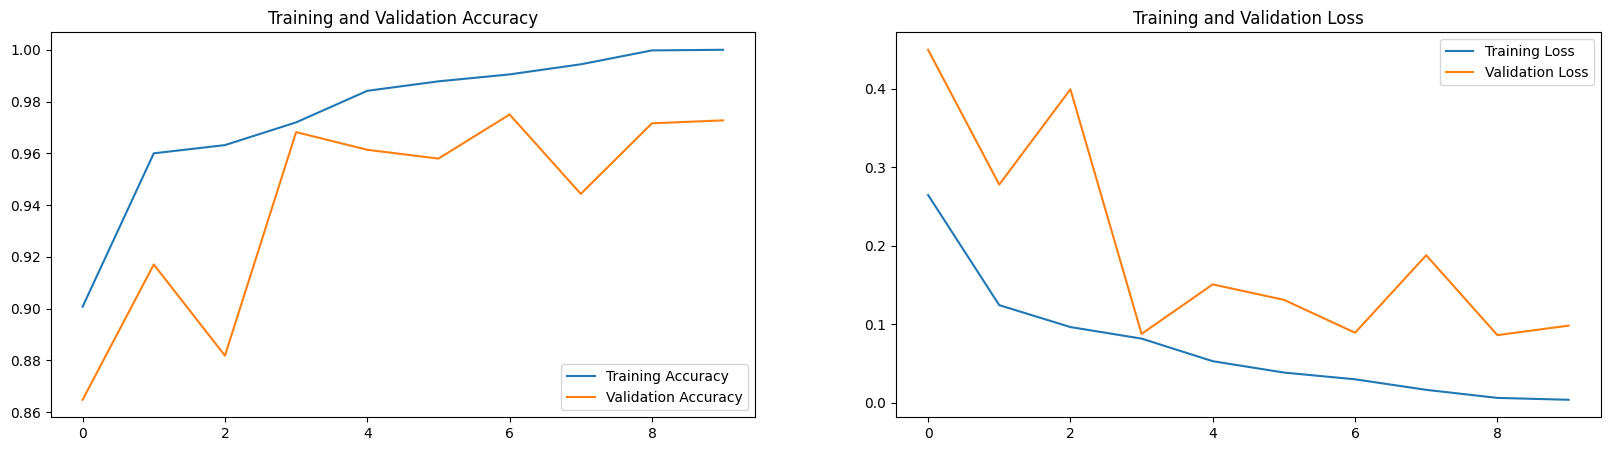

In [56]:
os.makedirs('validpic', exist_ok=True)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('validpic/training_vs_validation.png')
plt.show()

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step  


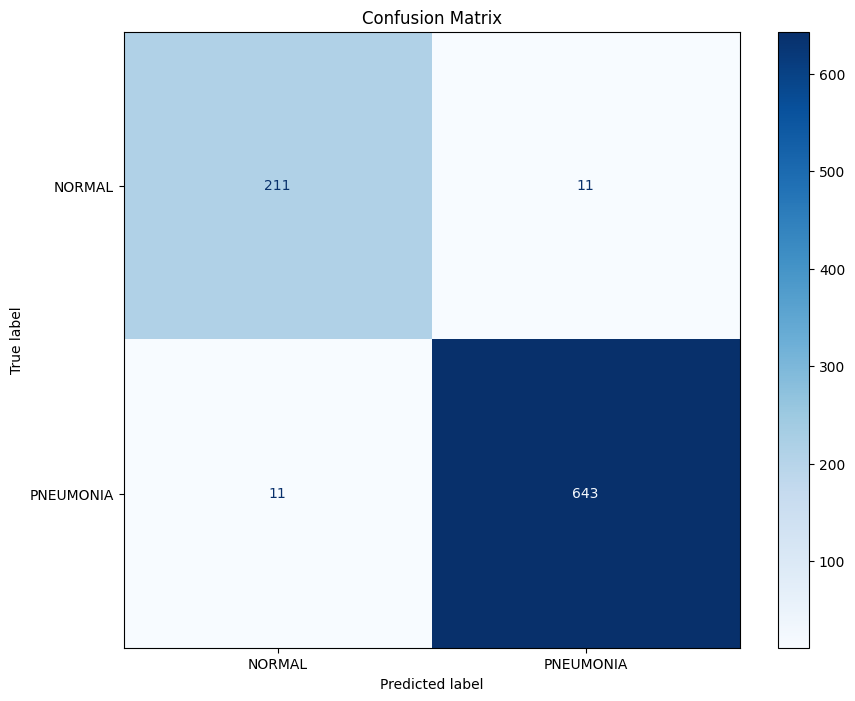

In [65]:
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)


y_true = []
for _, labels in test_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)


cm = confusion_matrix(y_true, y_pred_classes)



fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig('validpic/confusion_matrix.png')
plt.show()

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step


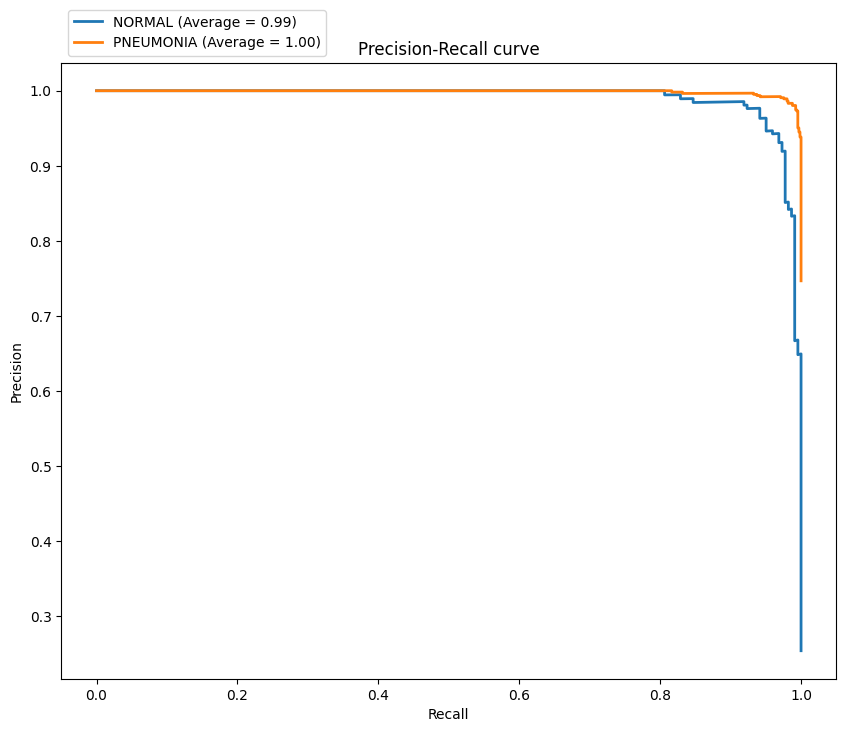

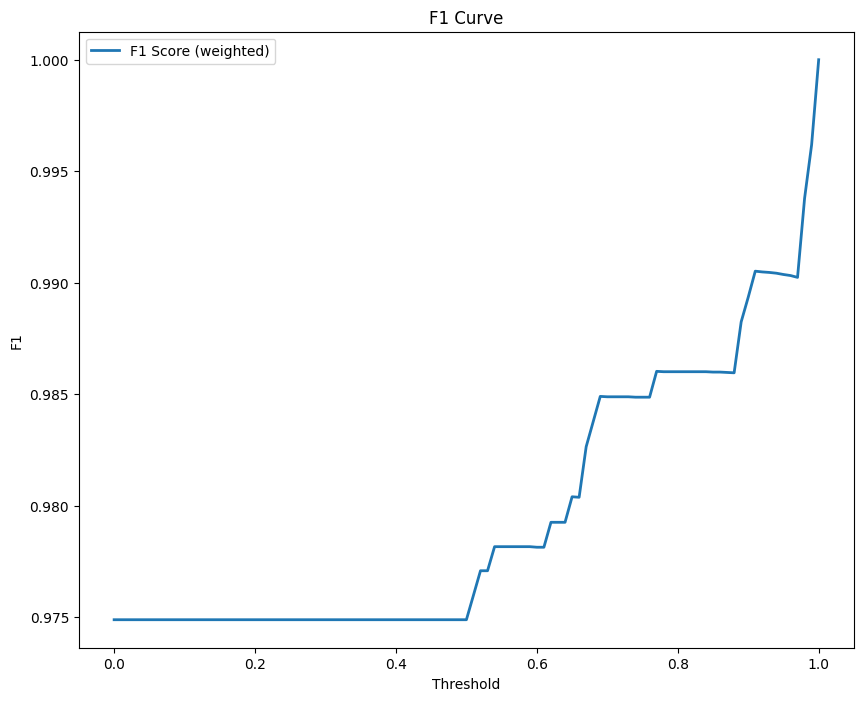

In [62]:
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)


y_true = []
for _, labels in test_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)


precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_pred[:, i])
    average_precision[i] = average_precision_score(y_true == i, y_pred[:, i])


plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'{class_names[i]} (Average = {average_precision[i]:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")
plt.legend(loc='lower left', bbox_to_anchor=(0, 1))
plt.savefig('validpic/precision_recall_curve.png')
plt.show()


y_pred_proba = np.max(y_pred, axis=1)           # ค่าความมั่นใจสูงสุด
y_pred_label = np.argmax(y_pred, axis=1)        # class ที่ predict

f1 = []
for t in thresholds:
    y_pred_thresh = [
        y_pred_label[i] if y_pred_proba[i] >= t else -1  # -1 = ทิ้ง sample นี้
        for i in range(len(y_true))
    ]
    # filter ทิ้ง -1 ก่อนคำนวณ F1
    valid_idx = [i for i, v in enumerate(y_pred_thresh) if v != -1]
    f1_t = f1_score(y_true[valid_idx], np.array(y_pred_thresh)[valid_idx], average="weighted")
    f1.append(f1_t)

# plt.axhline(f1[0], color='red', linestyle='--', label=f'Baseline F1 (t=0): {f1[0]:.2f}')
plt.figure(figsize=(10, 8))
plt.plot(thresholds, f1, lw=2, label="F1 Score (weighted)")
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.title("F1 Curve")
plt.legend()
plt.savefig('validpic/f1_curve.png')
plt.show()
